## Importing the required libraries

In [151]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import tensorflow.keras 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.densenet import DenseNet121

## Plotting the audio file's waveform and its spectrogram

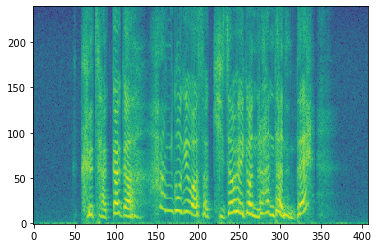

In [152]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('data/007_st_a_19.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [153]:
mylist_1= os.listdir('data/')
type(mylist_1)
mylist=[]
for item in mylist_1:
    if item[-3:]=='wav':
        mylist.append(item)

In [154]:
feeling_list=[]
for item in mylist:
    if item[-3:] == 'wav':
        if item[7:8] =='a':
            feeling_list.append('angry')
        elif item[7:8] =='n':
            feeling_list.append('neutral')
        elif item[7:8] =='s':
            feeling_list.append('sad')
        elif item[7:8] =='h':
            feeling_list.append('happy')
    else:
        pass
labels = pd.DataFrame(feeling_list)

## Getting the features of audio files using librosa

In [155]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    # if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        try:
            X, sample_rate = librosa.load('data/'+y, res_type='kaiser_fast',duration=2.5,sr=16000,offset=0.0)
            signal = np.zeros((int(sample_rate *3,)))
            signal[:len(X)] = X
            sample_rate = sample_rate
            mfccs = librosa.feature.mfcc(y=signal, 
                                            sr=sample_rate, 
                                            n_mfcc=32,
                                            )
        except:
            print(y)

                        
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [156]:
newdf = pd.concat([df,labels], axis=1)
for i in range(len(newdf)):

    newdf['feature'][i].astype('float64')

In [157]:
from sklearn.utils import shuffle
rnewdf = newdf.rename(index=str, columns={"0": "label"})
rnewdf = shuffle(newdf)
rnewdf[:10]
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [158]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [159]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [160]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = trainfeatures['feature']
y_train = np.array(trainlabel)
X_test = testfeatures['feature']
y_test = np.array(testlabel)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
X_train = np.stack(X_train)
X_test = np.stack(X_test)


/home/seojungin/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [161]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    model = DenseNet121(weights=None,input_shape=(32,94,1),classes=4)
    opt = tensorflow.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


/home/seojungin/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Removed the whole training part for avoiding unnecessary long epochs list

In [162]:
with tf.device('/device:GPU:0'): 
    cnnhistory=model.fit(np.asarray(X_train), y_train, batch_size=16, epochs=80, validation_data=(X_test, y_test))

Epoch 1/80


2022-04-22 17:33:56.036834: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_214445"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1266"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

101/143 [====================>.........] - ETA: 8s - loss: 1.3362 - accuracy: 0.3725

KeyboardInterrupt: 

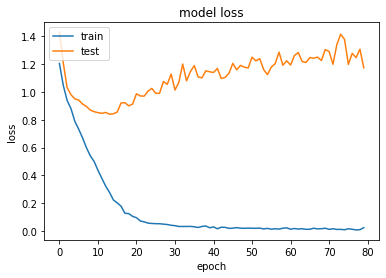

In [38]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [42]:
model_name = 'Emotion_DenseNet121.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/seojungin/practice/Speech-Emotion-Analyzer/saved_models/Emotion_DenseNet121.h5 


In [43]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [47]:
# loading json and creating model
from tensorflow.keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_DenseNet121.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
opt = tensorflow.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


/home/seojungin/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


accuracy: 69.07%


## Predicting emotions on the test data

In [49]:
preds = loaded_model.predict(X_test, 
                         batch_size=32, 
                         verbose=1)

19/19 [==============================] - 2s 61ms/step


In [51]:
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [56]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})

In [58]:
finaldf = actualdf.join(preddf)
finaldf.to_csv('Predictions.csv', index=False)

## Actual v/s Predicted emotions

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [130]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

def predicts(wav_path):
    
    X, sample_rate = librosa.load(wav_path, res_type='kaiser_fast',duration=2.5,sr=16000,offset=0.0)
    signal = np.zeros((48000))
    signal[:len(X)] = X
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=32)
    live=tf.expand_dims(mfccs,axis=0)
    livepreds = loaded_model.predict(live,batch_size=32,verbose=1)
    livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print(livepredictions)
    return livepredictions

UsageError: Line magic function `%` not found.


In [140]:
predicts('./data/004_dy_h_09.wav')

1/1 [==============================] - 0s 24ms/step
['happy']


array(['happy'], dtype=object)